<a href="https://colab.research.google.com/github/baddfish/DS-Unit-2-Applied-Modeling/blob/master/Tony_Maddalone_DS12_Sprint_Challenge_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_

# Applied Modeling Sprint Challenge: Predict Chicago food inspections 🍕

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

## **Part 1. Preprocessing BINARY CLASSIFICATION**
You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections.

#### Run this cell to install packages in Colab:

In [0]:
# 1 Import Libraries
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

#### Run this cell to load the data:

In [0]:
import pandas as pd

# 2A Import dataset

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

#####################################################
#          EVERYTHING ABOVE ALREADY CODED           #

In [41]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


In [42]:
# 3 Handling missing values

train.isna().sum()

Inspection ID         0
DBA Name              0
AKA Name            623
License #             5
Facility Type       224
Risk                 12
Address               0
City                 53
State                10
Zip                  26
Inspection Date       0
Inspection Type       1
Violations         9655
Latitude            198
Longitude           198
Location            198
Fail                  0
dtype: int64

In [43]:
# Determine majority class
target = 'Fail'
y_train = train[target]
y_train.value_counts(normalize=True)

0    0.74139
1    0.25861
Name: Fail, dtype: float64

In [44]:
train.head(1)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1


In [45]:
train['Fail'].describe()

count    51916.000000
mean         0.258610
std          0.437875
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: Fail, dtype: float64

In [46]:
train.isna().sum()

Inspection ID         0
DBA Name              0
AKA Name            623
License #             5
Facility Type       224
Risk                 12
Address               0
City                 53
State                10
Zip                  26
Inspection Date       0
Inspection Type       1
Violations         9655
Latitude            198
Longitude           198
Location            198
Fail                  0
dtype: int64

In [0]:
# train = train.drop(columns=['AKA Name', 'License #', 'Facility Type', 'City', 'State', 'Zip', 'Latitude', 'Longitude', 'Location'])
# train.head

In [0]:
import pandas as pd

def clean_dataset(train):
    assert isinstance(train, pd.DataFrame), "df needs to be a pd.DataFrame"
    train.dropna(inplace=True)
    indices_to_keep = ~train.isin([np.nan, np.inf, -np.inf]).any(1)
    return train[indices_to_keep].astype(np.float64)

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._

In [49]:
# Fit the model

from sklearn.model_selection import train_test_split
train, val = train_test_split(train, random_state=42)

train.shape, val.shape, test.shape


((38937, 17), (12979, 17), (17306, 17))

In [0]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline
# from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [51]:
# target = 'Fail' 
features = train.columns.drop([target])
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    # DecisionTreeClassifier(max_depth=3)
    XGBClassifier()
)

pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.7361121812158101


In [0]:

y_pred = pipeline.predict(X_val)


In [58]:
### ROC/AUC score

from sklearn.metrics import roc_auc_score
y_pred_proba = pipeline.predict_proba(X_val)[:, -1]
roc_auc_score(y_val, y_pred_proba)


0.6406198430008172

### Part 3: Visualization

Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:

- Confusion Matrix
- Permutation Importances
- Partial Dependence Plot, 1 feature isolation
- Partial Dependence Plot, 2 features interaction
- Shapley Values

_To earn a score of 3 for this part, make four of these visualization types._

In [55]:
# CONFUSION MATRIX 224

from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred)

array([[9552,    1],
       [3424,    2]])

In [0]:
from sklearn.metrics import r2_score
from xgboost import XGBRFClassifier

gb = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier()
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)

In [0]:
# PLOT DEPENDANCE WITH 1 feature
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Risk'

isolated = pdp_isolate(
    model=gb,
    dataset=X_val,
    model_features=X_val.columns,
    feature=features
)

pdp_plot(isolated, feature_name=feature)


In [75]:
from xgboost import XGBRFClassifier
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline


pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.7333384698358888


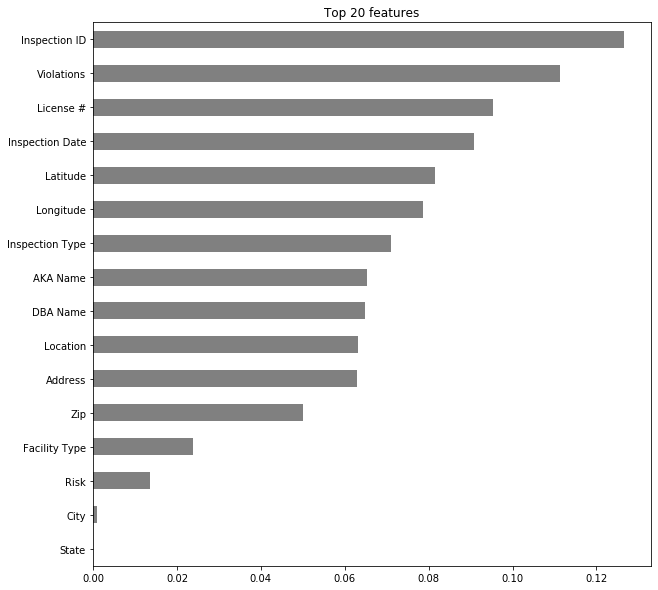

In [77]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');